# Fake Followers of @TariqRamadan on Twitter

Today we will use fully open data provided by Twitter's public API to look for paid or fake followers in a Twitter account. You can apply the same technique to any Twitter account. We will be using the account of [@TariqRamadan](https://twitter.com/TariqRamadan).

Fake Twitter users, who were either created to simply increase the number of followers or spread spam messages are an old phenomenon. It's surprising people still use the technique, even though it's quite easy to detect.

Before diving into the data, we will look at existing research and best practices. In grey literature, we find Sparktoro[^1], who bought fake Twitter users themselves, then looked at attributes and came up with a score to assess an account based on a small sample of it's followers. This is usefule to get a quick overview. The criteria they use are easy to retrieve, so we will reuse them as well:

- Profile image – accounts lacking these are often spam
- Account age in days – certain patterns are clearly spam-correlated
- Number of followers – spam accounts tend to have very few followers
- Days since last tweet – many spam accounts rarely if ever send tweets
- Number of times the account appears on lists – spam accounts are almost never on lists
- Display name – certain keywords and patterns correlate strongly with spam

In the official literature, we find a good paper by Stefano Cresci et al[^2]. They summarize different criteria used by previous papers and build their own machine learning model with a data set of known humans and bots. Unfortunately we don't have access to their model, so we will just reuse some of the criteria (table 14) they used to detect bot users:

- has name
- has image
- has biography
- followers ≥ 30
- tweets ≥ 50

### Resources
- 1: https://sparktoro.com/blog/sparktoros-new-tool-to-uncover-real-vs-fake-followers-on-twitter/
- 2: https://arxiv.org/pdf/1509.04098.pdf
- 3: https://developer.twitter.com/en/docs

## Input data

The data used for this report was downloaded on Nov 8, 2019 using Twitter's official API[^3]. In total we received 697,784 IDs of followers, of which we were able to get details for 697,765.

**The source data is included with this repo for your convenience and to easily run your own analysis. To validate our result you could also download the data again yourself.**

In [1]:
df = pd.read_parquet('follower_details.parquet')

In [2]:
import pickle
ids = pickle.load(open('follower_ids.pickle', 'rb'))
total_n = len(df)
'Number of followers received:', len(ids)

('Number of followers received:', 697784)

In [3]:
'Number of follower details received:', len(df)

('Number of follower details received:', 697765)

### Suspicious usernames

Human users usually choose a human-readable name with few digits. Usernames with more than 4 digits often point to machine-generated usernames. For Tariq Ramadan, almost 100k followers have usernames that have a lot of numbers in their username.

Below a small selection.

In [4]:
def count_digits(string):
    return sum(item.isdigit() for item in string)

df['screen_name_digits'] = df['screen_name'].apply(count_digits)

In [5]:
'Users with an excess number of digits in their username', len(df[df.screen_name_digits > 4].screen_name.sort_values())

('Users with an excess number of digits in their username', 94478)

In [6]:
df[df.screen_name_digits > 4].screen_name.sort_values().tail(30)

id
4697871612                  zozi27100
798743098717310976       zozo08330619
895051203469619202          zozo10044
815494618594807808       zozo63559387
850858256364953600       zozo72653296
4843211661               zozo90324803
4898941899               zozo91916433
872838547849588736        zozo9876541
4776316582                 zr58850585
4844683125                 zr76417735
3025383327                zraidi00002
866396398836699140    zri9a2008livef2
853325106214559744    zsMpiNw730QY20x
276203862                 zubair13500
4897593400            zubaira01728914
743746439344336896    zubairb18627490
173428341                zulfi5241786
1924109617            zulfiqa79543714
973434869807161344    zulkifl50051282
3120654308                  zura24589
785863944082710528           zuu48286
778856856974401536           zvb04835
2168744119               zyad20031968
827661032             zynb43578900765
3056984182                    zz00007
723853958398259201           zz506518
726777765

## Users without bio

Human users usually add their biography. For TR's users, **70%** of followers have no bio.

In [7]:
'Percent of followers without description:', len(df[df.description.isnull()]) / total_n

('Percent of followers without description:', 0.700655664872844)

## New followers created in March 2018

It seems that many of TR's follower accounts were created on a small number of days, often at the beginning of 2018. Generally we would expect the time new follower accounts are created to be random. For TR's followers, the number has some suspicious spikes in 2017 and 2018, as well as a smaller on in 2015.

When grouping the creation date by day, we find that about 1000 accounts each were created on March 1, 2, 25 and 26.

For accounts created on that day, 70% have one or less tweets until now and 64% never updated their profile picture. As a result it's save to assume that most of those accounts are fake.

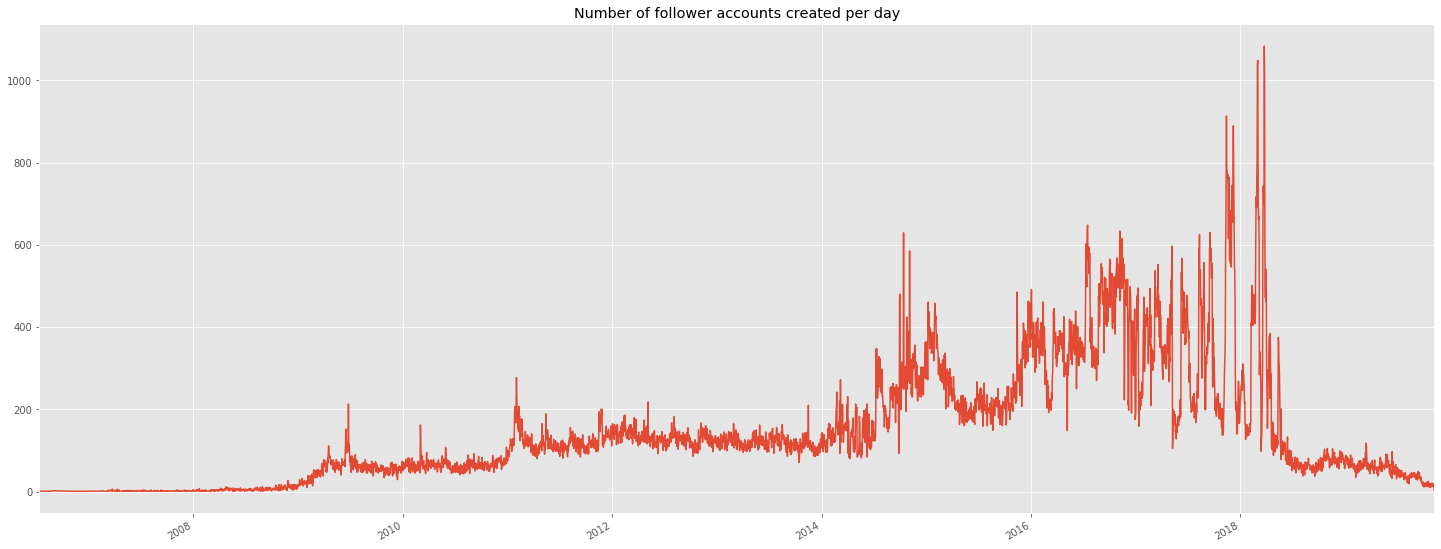

In [8]:
df.created_at.dt.floor('d').value_counts().plot(figsize=(25, 10), title='Number of follower accounts created per day')

In [9]:
df.created_at.dt.floor('d').value_counts().head(15)

2018-03-25 00:00:00+00:00    1083
2018-03-02 00:00:00+00:00    1048
2018-03-01 00:00:00+00:00    1036
2018-03-26 00:00:00+00:00    1015
2017-11-13 00:00:00+00:00     913
2017-12-07 00:00:00+00:00     889
2018-03-03 00:00:00+00:00     861
2017-12-06 00:00:00+00:00     811
2018-02-28 00:00:00+00:00     806
2017-12-08 00:00:00+00:00     795
2017-11-14 00:00:00+00:00     790
2017-11-12 00:00:00+00:00     783
2017-11-15 00:00:00+00:00     780
2017-11-17 00:00:00+00:00     772
2017-11-18 00:00:00+00:00     770
Name: created_at, dtype: int64

Let's look at one particular day, March 25. On this day, 1083 of Tariq's followers were created. Of those accounts, **758 never sent more than 1 tweet and 64% never changed their profile picture**. This is a strong indication that most accounts created on that day were only set up to increase Tariq Ramadan's follower count.

In [10]:
created_mar_25 = df[(df.created_at > '2018-03-25') & (df.created_at < '2018-03-26')]

In [11]:
created_mar_25.statuses_count.value_counts(dropna=False).head()

NaN    580
1.0    178
2.0     85
3.0     57
4.0     34
Name: statuses_count, dtype: int64

In [13]:
default_img = 'http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png'

'Percent of followers created on Mar 25, 2018, still using the default profile image', \
    len(created_mar_25[created_mar_25.profile_image_url == default_img]) / len(created_mar_25)

('Percent of followers created on Mar 25, 2018, still using the default profile image',
 0.6435826408125577)

## Followers with very few tweets

Human users generally post tweets over time. TR's followers are relatively silent. **63.9% have fewer than 10 tweets**.

In [14]:
df.statuses_count.value_counts(dropna=False).head(10)

NaN    239320
1.0     77653
2.0     40243
3.0     25310
4.0     17865
5.0     13562
6.0     10549
7.0      8497
8.0      7046
9.0      6258
Name: statuses_count, dtype: int64

In [15]:
'Percent of followers with fewer than 10 tweets', _.sum()/total_n

('Percent of followers with fewer than 10 tweets', 0.6396179229396717)

## Users with very few followers

Human users usually gain some followers over time. For TR's followers, 60% have fewer than 10 followers.

In [16]:
df.followers_count.value_counts(dropna=False).head(10)

NaN    119756
1.0     87031
2.0     56883
3.0     40570
4.0     30460
5.0     23997
6.0     19828
7.0     16475
8.0     14035
9.0     12047
Name: followers_count, dtype: int64

In [17]:
'Percent of followers with fewer than 10 followers', _.sum()/total_n

('Percent of followers with fewer than 10 followers', 0.6034725158183629)

## Users without location

Human users usually set their current location in their profile. For TR's followers, 70% have no location set.

In [18]:
'Percent of followers without location set:', len(df[df.location.isnull()])/total_n

('Percent of followers without location set:', 0.7023424792014503)

## Followers with default profile image

Human users usually add a picture to their profile. For TR's users, 38% of followers still use the default image.

In [19]:
'Percent of followers with default profile image:', len(df[(df.profile_image_url == default_img)])/total_n

('Percent of followers with default profile image:', 0.3811856427307188)

## Followers on lists

Twitter allows users to create lists of users, relevant to a specific topic. For TR's followers, 85% never show up on any list.

In [20]:
'Percent of followers not on any list:', len(df[df.listed_count.isnull()])/total_n

('Percent of followers not on any list:', 0.8527211883657105)

## Followers publishing a status update on the day of creation

Human users would continually add status updates. For TR's followers, 15% published their last status update within 10 days of account creation and then never again.

45% of his followers were inactive for more than 120 days.

In [21]:
# (pd.Timestamp.now(tz='UTC')- df.tweet_created_at).dt.days.hist(bins=50)
update_within_10_days = (df.tweet_created_at - df.created_at).dt.days.value_counts().head(10).sum()
'Users publishing their only status update within 10 days of account creation', update_within_10_days/total_n

('Users publishing their only status update within 10 days of account creation',
 0.15797152336388326)

In [22]:
sum((pd.Timestamp.now(tz='UTC')- df.tweet_created_at).dt.days > 120) / total_n

0.45297198913674375

## Estimate of real followers

Using the metrics above and four criteria mentioned in the intro, we find that only 14.3% of Tariq Ramadan's followers fulfill all the strong criteria of being human. The rest exhibits a degree of bot behavior and missing attributes.

Of course, no single attribute can identify a bot with full convidence, so a sample dataset and machine learning model would be needed for a precise estimate.

But even after this initial analysis, we can confidently say that the majority of Tariq Ramadan's Twitter followers are just bots. Congest Twitter's network only to increase his follower count.

In [23]:
real_users = df[
    (df.profile_image_url != default_img) &
    (df.followers_count > 30) &
    (df.statuses_count > 50) &
    (df.description.notnull()) &
    (df.name.notnull())
]
len(real_users) / total_n

0.14314131548587275

## Summary

In this analysis, we looked at the Twitter followers of Tariq Ramadan, a famous celebrity from France. We find that many of his followers are inactive or miss basic details that a human account would have. Like adding a location, description or having followers of their own.

We also find that many of his followers were created on just a few days in 2018 and 2017. Of those highly suspicious followers, 75% never published more than one tweet and 63% never changed their profile image. Both features strongly indicate bot accounts.

When applying the most basic profile-based criteria to his followers, we find that only 14% would pass as human. So without applying a full machine learning model **we can conclude after this exploratory analysis that between 60% and 85% of Tariq Ramadan's Twitter followers are not human**.

As always, we encourage you to look at the data yourself. To do so just clone this repo or run it on MyBinder.